#### Imports

In [1]:
import sys, subprocess
# System operations
import os
os.environ["OPTUNA_WORKER_ID"] = os.getenv("OPTUNA_WORKER_ID", "0")
# pin GPU per kernel or set "" to force CPU
os.environ["CUDA_VISIBLE_DEVICES"] = os.getenv("CUDA_VISIBLE_DEVICES", "0")
# reduce thread contention
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")

WORKER_ID = int(os.getenv("OPTUNA_WORKER_ID", "0"))
print("WORKER_ID:", WORKER_ID, "CUDA_VISIBLE_DEVICES:", os.environ.get("CUDA_VISIBLE_DEVICES"))

# Type hinting
from typing import Any, List, Mapping, Tuple, Union

# Data visualization
import matplotlib.pyplot as plt

# Data manipulation
import numpy as np
import pandas as pd
import gymnasium as gym
import torch as th
import copy, time, json, pickle

# CityLearn
import citylearn
from citylearn.data import DataSet
from citylearn.wrappers import NormalizedObservationWrapper, StableBaselines3Wrapper
from citylearn.citylearn import CityLearnEnv

# RL algorithms
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor

# Utils
from utils.env_utils import DiscretizeActionWrapper, keep_only_electrical_storage, keep_only_core_observations

# Debugging
print('Python:', sys.version.split()[0])
print('Torch :', th.__version__)
print('CityLearn:', citylearn.__version__)
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "optuna", "optuna-dashboard"])
print("Optuna installed.")

WORKER_ID: 0 CUDA_VISIBLE_DEVICES: MIG-3506b3a5-ecbb-5eba-80f8-9efaecbb2049
Couldn't import dot_parser, loading of dot files will not be possible.


2025-10-14 13:17:21.848148: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-14 13:17:21.861178: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760440641.875415 3663222 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760440641.879377 3663222 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760440641.890306 3663222 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Python: 3.11.7
Torch : 2.7.0+cu126
CityLearn: 2.4.1
Optuna installed.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /hkfs/home/haicore/iai/cj9272/citylearn_env/bin/python -m pip install --upgrade pip


#### Variables

In [2]:
DATASET_NAME = 'citylearn_challenge_2023_phase_3_1' 
ROOT_DIR = r'/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1'
LOG_DIR = r'/hkfs/home/haicore/iai/cj9272/logs/dqn'
REWARD_FN = {  # CostReward 
    'type': 'citylearn.reward_function.CostReward',
    'attributes': {}
}
PRICING_FILE = 'pricing_germany_2023_june_to_august.csv'
ACTION_LABELS = ['discharge_full','discharge_half','idle','charge_half','charge_full']
NAME_TO_FRAC = {
    'discharge_full': -1.0, 
    # energy = -1*capacity,
    # diff = soc_init-0.2 e.g. diff = 0.8
    # -(diff*capacity*sqrt(0.95)) e.g. -0.77
    # max_output_power = 3.32 * capacity_power_curve values 
    # (Given the current SoC, look up the max allowed output power fraction
    # from the curve (by linear interpolation) and multiply 
    # by the system’s nominal power to get max_output_power)
    # energy = max(-max_output_power, -(diff*capacity*sqrt(0.95)), -1*capacity)
    'discharge_half': -0.5,
    'idle': 0.0,
    'charge_half': 0.5,
    'charge_full': 1.0,
}
INT_TO_FRAC = np.array([NAME_TO_FRAC[n] for n in ACTION_LABELS], dtype=np.float32)
EVAL_EPISODES = 10

In [3]:
observations = [
    # building_df
    'month', 'hour', 'day_type', 'daylight_savings_status',
    'indoor_dry_bulb_temperature',
    'average_unmet_cooling_setpoint_difference',
    'indoor_relative_humidity',
    'non_shiftable_load', 'dhw_demand',
    'cooling_demand', 'heating_demand',
    'solar_generation', 'occupant_count',
    'indoor_dry_bulb_temperature_cooling_set_point',
    'indoor_dry_bulb_temperature_heating_set_point', 'hvac_mode',
    # weather_df
    'outdoor_dry_bulb_temperature',
    'outdoor_relative_humidity',
    'diffuse_solar_irradiance',
    'direct_solar_irradiance',
    'outdoor_dry_bulb_temperature_predicted_1',
    'outdoor_dry_bulb_temperature_predicted_2',
    'outdoor_dry_bulb_temperature_predicted_3',
    'outdoor_relative_humidity_predicted_1',
    'outdoor_relative_humidity_predicted_2',
    'outdoor_relative_humidity_predicted_3',
    'diffuse_solar_irradiance_predicted_1',
    'diffuse_solar_irradiance_predicted_2',
    'diffuse_solar_irradiance_predicted_3',
    'direct_solar_irradiance_predicted_1',
    'direct_solar_irradiance_predicted_2',
    'direct_solar_irradiance_predicted_3',
    # carbon_df 
    'carbon_intensity',
    # pricing_df
    'electricity_pricing',
    'electricity_pricing_predicted_1',
    'electricity_pricing_predicted_2',
    'electricity_pricing_predicted_3'
]
bld_cols = [
            'month', 'hour', 'day_type', 'daylight_savings_status',
            'indoor_dry_bulb_temperature',
            'average_unmet_cooling_setpoint_difference',
            'indoor_relative_humidity', 'non_shiftable_load',
            'dhw_demand', 'cooling_demand', 'heating_demand',
            'solar_generation', 'occupant_count',
            'indoor_dry_bulb_temperature_cooling_set_point',
            'indoor_dry_bulb_temperature_heating_set_point',
            'hvac_mode'
]
wth_cols = [
    'outdoor_dry_bulb_temperature',
    'outdoor_relative_humidity',
    'diffuse_solar_irradiance',
    'direct_solar_irradiance'
]

In [4]:
# --- Load schema ---
dataset = DataSet()
schema = dataset.get_schema(DATASET_NAME)
schema['root_directory'] = ROOT_DIR
schema['reward_function'] = REWARD_FN

price_file = PRICING_FILE # Set pricing file
if 'buildings' not in schema:
    raise RuntimeError("schema does not contain 'buildings' (make sure schema is loaded first)")
for bname, bconf in schema['buildings'].items():
    bconf['pricing'] = price_file

schema = keep_only_electrical_storage(schema) # Activate only the electrical storage control (fix "Expected 18 actions but got 1")
schema = keep_only_core_observations(schema, extra_keep=['carbon_intensity', 'non_shiftable_load'], drop_predictions=False)

top_obs = schema.get('observations', {})
active_top = [k for k,v in top_obs.items() if isinstance(v, dict) and v.get('active', False)]
print("Top-level active before:", active_top)

INFO:root:Go here /home/iai/cj9272/.cache/citylearn/v2.4.1/datasets/citylearn_challenge_2023_phase_3_1/schema.json 


Top-level active before: ['carbon_intensity', 'non_shiftable_load', 'solar_generation', 'electrical_storage_soc', 'net_electricity_consumption', 'electricity_pricing']


In [5]:
class TrainLoggerCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.rows = []
        self.losses = []
        self.loss_timesteps = []
        self.episode_rewards = []
        self._current_ep_rewards = []
        self._current_ep_counts = []
        self._current_step_in_episode = []
        self.df = pd.DataFrame()
        self.ep_df = pd.DataFrame()
        self._obs_names = None

    def _get_citylearn_env_for_idx(self, idx: int):
        from citylearn.citylearn import CityLearnEnv
        env = self.training_env
        try:
            sub = env.envs[idx]
        except Exception:
            sub = getattr(env, "env", getattr(env, "unwrapped", env))
        seen = set()
        cur = sub
        while cur is not None and id(cur) not in seen:
            if isinstance(cur, CityLearnEnv):
                return cur
            seen.add(id(cur))
            cur = getattr(cur, "env", getattr(cur, "unwrapped", None))
        return None

    def _on_training_start(self) -> None:
        try:
            n_envs = self.training_env.num_envs
        except AttributeError:
            n_envs = 1
        self._current_ep_rewards = [0.0] * n_envs
        self._current_ep_counts = [1] * n_envs
        self._current_step_in_episode = [0] * n_envs
        # capture observation names (single-building case)
        try:
            base = self._get_citylearn_env_for_idx(0)
            if base is not None:
                self._obs_names = list(base.observation_names[0])
        except Exception:
            self._obs_names = None
        super()._on_training_start()

    def _on_step(self) -> bool:
        obs_vec = self.locals.get("new_obs")
        acts    = self.locals.get("actions")
        rews    = self.locals.get("rewards")
        dones   = self.locals.get("dones")
        step    = int(self.num_timesteps)

        loss_val = self.logger.name_to_value.get("train/loss")
        if loss_val is not None:
            self.losses.append(float(loss_val))
            self.loss_timesteps.append(step)

        for idx, (obs, act, rew, done) in enumerate(zip(obs_vec, acts, rews, dones)):
            row = {}
            # Basic step metadata
            row.update({
                "global_step": step,
                "env_id": idx,
                "episode": self._current_ep_counts[idx],
                "action_id": int(act),
                "reward": float(rew),
            })

            # Optional: action label & mapped fraction
            try:
                a_id = int(act)
                row['action_label'] = ACTION_LABELS[a_id]
                row['action_frac'] = float(INT_TO_FRAC[a_id])
            except Exception:
                row['action_label'] = None
                row['action_frac'] = None

            # Pull CityLearn internals for consistent indexing
            try:
                base = self._get_citylearn_env_for_idx(idx)
                if base is not None:
                    b = base.buildings[0]
                    t  = b.time_step
                    tp = max(0, t-1)  # previous step = the one your obs net_load refers to

                    # Robust chargers
                    chargers_arr = getattr(b, "_Building__chargers_electricity_consumption", None)
                    chargers_tp = float(chargers_arr[tp]) if chargers_arr is not None else float('nan')
                    chargers_t  = float(chargers_arr[t])  if chargers_arr is not None else float('nan')

                    # Component loads on tp (this is the consistent balance slice)
                    row.update({
                        "price": float(b.pricing.electricity_pricing[tp]),
                        "net_load": float(b.net_electricity_consumption[tp]),
                        "non_shiftable_load": float(b.non_shiftable_load_device.electricity_consumption[tp]),
                        "cooling_load": float(b.cooling_device.electricity_consumption[tp]),
                        "heating_load": float(b.heating_device.electricity_consumption[tp]),
                        "dhw_load": float(b.dhw_device.electricity_consumption[tp]),
                        "chargers_load": chargers_tp,
                        "storage_load": float(b.electrical_storage.electricity_consumption[tp]),
                        "solar": float(b.solar_generation[tp]),  # negative for generation
                        "battery_soc": float(b.electrical_storage.soc[tp]),
                        "battery_energy_balance": float(b.electrical_storage.energy_balance[tp]),
                        "simulate_power_outage": bool(getattr(b, 'simulate_power_outage', False)),
                        "power_outage": bool(getattr(b, 'power_outage', False)),
                    })

                # If base is None, we still keep the obs-based fields we already wrote
            except Exception:
                pass

            self.rows.append(row)

            # bookkeeping
            self._current_ep_rewards[idx] += float(rew)
            self._current_step_in_episode[idx] += 1
            if done:
                self.episode_rewards.append(self._current_ep_rewards[idx])
                self._current_ep_rewards[idx] = 0.0
                self._current_step_in_episode[idx] = 0
                self._current_ep_counts[idx] += 1

        return True

    def _on_training_end(self) -> None:
        self.df = pd.DataFrame(self.rows)
        self.ep_df = pd.DataFrame({
            "episode_global": range(1, len(self.episode_rewards) + 1),
            "return": self.episode_rewards
        })
        super()._on_training_end()

#### Training

In [6]:
# Keep only one building: 1-D action
one_building = "Building_1"
schema_1b = dict(schema)  # shallow copy
schema_1b['buildings'] = {k: v for k, v in schema['buildings'].items() if k == one_building}
if not schema_1b['buildings']:
    raise RuntimeError(f"{one_building} not found in schema['buildings']")

train_env = CityLearnEnv(schema_1b, central_agent=True)
train_env = NormalizedObservationWrapper(train_env)
train_env = StableBaselines3Wrapper(train_env)
# Discretize action space for DQN
train_env = DiscretizeActionWrapper(train_env, n_bins=5)
train_env = Monitor(train_env)

b = train_env.unwrapped.buildings[0]
print(b.active_actions)
print("Battery capacity:", b.electrical_storage.capacity)
print("Battery nominal power:", getattr(b.electrical_storage, "nominal_power", "N/A"))
print("Action names:", train_env.unwrapped.action_names)
print("Action space:", train_env.action_space)

print("Battery attributes:", dir(b.electrical_storage))
print("Initial SOC:", b.electrical_storage.initial_soc)
print("SOC (full array):", b.electrical_storage.soc)
print("First 20 SOC values:", b.electrical_storage.soc[:20])
print("Current timestep:", b.time_step)
print("Current SOC:", b.electrical_storage.soc[b.time_step])
print("Total timesteps:", train_env.unwrapped.time_steps)

train_callback = TrainLoggerCallback()


T = 2207  # 2207 timesteps per episode
num_episodes = 50 # 50 episodes for training
TOTAL_TIMESTEPS = num_episodes * T
"""
model = DQN(
    policy='MlpPolicy',
    env=train_env,
    seed=0,
    #learning_starts=1000,
    learning_rate=1.1131267357743944e-05,
    gamma=0.9617017861578802,
    buffer_size=150000,
    batch_size=64,
    tau=0.05065165487856718,
    target_update_interval=3500,
    train_freq=1,
    gradient_steps=3,
    exploration_fraction=0.2847232543663558,
    exploration_final_eps=0.028934430496645687,
    learning_starts=1000,
    verbose=1, # logging: info
    policy_kwargs=dict(net_arch=[512, 512], activation_fn=th.nn.ReLU),
)
"""
# Best parameters found by optuna
model = DQN(
    policy='MlpPolicy',
    env=train_env,
    seed=0,
    learning_rate=0.0002752350841138598,
    gamma=0.9851293040985031,
    buffer_size=125000,
    batch_size=256,
    tau=0.05065165487856718,
    target_update_interval=3500,
    train_freq=5,
    gradient_steps=4,
    exploration_fraction=0.18063198209981218,
    exploration_final_eps=0.05601773593918628,
    learning_starts=1000,
    verbose=1, # logging: info
    policy_kwargs=dict(net_arch=[512, 512], activation_fn=th.nn.ReLU),
)
TRAINING_FILE = "dqn_train_test_split" # xxx
TRAIN_STEPS_FILE = os.path.join(LOG_DIR, "dqn_train_steps_50episodes_train_test_split.csv") # xxx
TRAIN_EPISODES_FILE = os.path.join(LOG_DIR, "dqn_train_50episodes_train_test_split.csv") # xxx

/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-10-14_13-17-28'
['electrical_storage']
Battery capacity: 4.0
Battery nominal power: 3.32
Action names: [['electrical_storage']]
Action space: Discrete(5)
Battery attributes: ['DEFAULT_RANDOM_SEED_RANGE', 'DEFAULT_SECONDS_PER_TIME_STEP', '_Battery__capacity_loss_coefficient', '_Battery__capacity_power_curve', '_Battery__depth_of_discharge', '_Battery__power_efficiency_curve', '_Battery__time_step_ratio', '_Device__efficiency', '_ElectricDevice__electricity_consumption', '_ElectricDevice__nominal_power', '_Environment__episode_tracker', '_Environment__random_seed', '_Environment__seconds_per_time_step', '_Environment__time_step', '_Envi

In [ ]:
start_time = time.time()
model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=train_callback)
print(f"Total time elapsed for {TOTAL_TIMESTEPS} steps: {(time.time()-start_time):.2f} seconds")
model.save(TRAINING_FILE)
print("---------------Train callback: \n", train_callback.df)
print("---------------Episode rewards: \n", train_callback.ep_df)
# Save training logs
train_callback.df.to_csv(TRAIN_STEPS_FILE, index=False)
train_callback.ep_df.to_csv(TRAIN_EPISODES_FILE, index=False)

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.21e+03 |
|    ep_rew_mean      | -272     |
|    exploration_rate | 0.582    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 13       |
|    time_elapsed     | 677      |
|    total_timesteps  | 8828     |
| train/              |          |
|    learning_rate    | 0.000275 |
|    loss             | 0.00492  |
|    n_updates        | 6260     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.21e+03 |
|    ep_rew_mean      | -270     |
|    exploration_rate | 0.164    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 14       |
|    time_elapsed     | 1256     |
|    total_timesteps  | 17656    |
| train/              |          |
|    learning_rate    | 0.000275 |
|    loss             | 0.00434  |
|    n_updates      

In [10]:
# Print SoC for the first 10 timesteps after training
b = train_env.unwrapped.buildings[0]
print("First 10 SoC values after training:")
print([b.electrical_storage.soc[t] for t in range(min(10, len(b.electrical_storage.soc)))])
print("Current timestep:", b.time_step)
print("Current SoC:", b.electrical_storage.soc[b.time_step])

First 10 SoC values after training:
[np.float32(0.2), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0)]
Current timestep: 0
Current SoC: 0.2


In [12]:
# View first rows from training logs
df = pd.read_csv(TRAIN_STEPS_FILE)

eps = 1e-4
cmd_neg = df['action_frac'] < 0
real_neg = df['storage_load'] < -eps
real_zero = df['storage_load'].abs() <= eps

print("share of discharge actions:", cmd_neg.mean())
print("…but realized zero (empty/limited):", (cmd_neg & real_zero).mean())
print("…and realized discharge:", (cmd_neg & real_neg).mean())

# correlation: do actions actually influence the battery?
print("corr(action_frac, storage_load):", df[['action_frac','storage_load']].corr().iloc[0,1])

share of discharge actions: 0.8073495375502132
…but realized zero (empty/limited): 0.702125584158767
…and realized discharge: 0.10522395339144623
corr(action_frac, storage_load): 0.5643762788218919


#### Evaluation

In [7]:
schema_eval = copy.deepcopy(schema_1b)
eval_env = CityLearnEnv(schema_eval, central_agent=True)
eval_env = NormalizedObservationWrapper(eval_env)
eval_env = StableBaselines3Wrapper(eval_env)
eval_env = DiscretizeActionWrapper(eval_env, n_bins=5)

model = DQN.load(TRAINING_FILE, env=eval_env)
print(f"DQN model loaded from {os.path.abspath(TRAINING_FILE)}")
EVAL_FILE = os.path.join(LOG_DIR, "dqn_eval_10episodes_1seed_train_test_split.pkl") # xxx

/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-10-14_13-17-35'


FileNotFoundError: [Errno 2] No such file or directory: 'dqn_train_test_split.zip'

In [12]:
# ca min
# Eval: collect discrete actions and rewards per step
def eval_dqn(model, eval_env, schema, episodes=3, deterministic=True): 
    """Deterministic eval that returns actions/rewards and per-step observation series for plots."""
    # unwrap to CityLearnEnv (inline to avoid external dependency order)
    def _get_base_env(env):
        cur, seen = env, set()
        while cur is not None and id(cur) not in seen:
            seen.add(id(cur))
            if isinstance(cur, CityLearnEnv):
                return cur
            cur = getattr(cur, "env", getattr(cur, "unwrapped", None))
        raise RuntimeError("CityLearnEnv not found inside wrappers.")

    base = _get_base_env(eval_env)

    # Building index (use Building_1 if present)
    bld_names = [b.name for b in base.buildings]
    building_name = 'Building_1' if 'Building_1' in bld_names else bld_names[0]
    b_idx = bld_names.index(building_name)

    # Observation indices for requested building
    obs_names = getattr(base, 'observation_names', None)
    if obs_names is None:
        raise AttributeError("CityLearnEnv has no 'observation_names'.")
    obs_b = obs_names[b_idx]
    name_to_idx = {n: i for i, n in enumerate(obs_b)}
    i_net = name_to_idx.get('net_electricity_consumption')
    if i_net is None:
        i_net = name_to_idx.get('net_electricity_consumption_without_storage')
    i_nsl   = name_to_idx.get('non_shiftable_load')
    i_price = name_to_idx.get('electricity_pricing')
    i_solar = name_to_idx.get('solar_generation')

    ep_lengths, actions_disc_list, step_rewards_all = [], [], []
    ep_action_fracs, ep_rewards_list = [], []
    ep_net_load, ep_non_shiftable_load, ep_price, ep_solar_generation = [], [], [], []

    for _ in range(episodes):
        obs, _ = eval_env.reset()
        done = False

        ep_actions, ep_fracs, ep_rewards = [], [], []
        ep_net, ep_nsl, ep_prc, ep_sol = [], [], [], []

        while not done:
            act_disc, _ = model.predict(obs, deterministic=deterministic)
            obs, r, terminated, truncated, _ = eval_env.step(act_disc)
            done = bool(terminated or truncated)

            a_id = int(act_disc)
            ep_actions.append(a_id)
            ep_fracs.append(float(INT_TO_FRAC[a_id]))
            ep_rewards.append(float(r))

            raw = base.observations[b_idx]
            ep_net.append(float(raw[i_net]) if i_net is not None else np.nan)
            ep_nsl.append(float(raw[i_nsl]) if i_nsl is not None else np.nan)
            ep_prc.append(float(raw[i_price]) if i_price is not None else np.nan)
            ep_sol.append(float(raw[i_solar]) if i_solar is not None else np.nan)

        ep_lengths.append(len(ep_rewards))
        actions_disc_list.append(np.array(ep_actions, dtype=int))
        step_rewards_all.extend(ep_rewards)
        ep_action_fracs.append(np.array(ep_fracs, dtype=float))
        ep_rewards_list.append(np.array(ep_rewards, dtype=float))
        ep_net_load.append(np.array(ep_net, dtype=float))
        ep_non_shiftable_load.append(np.array(ep_nsl, dtype=float))
        ep_price.append(np.array(ep_prc, dtype=float))
        ep_solar_generation.append(np.array(ep_sol, dtype=float))

    # Pricing file info (kept for compatibility)
    price_file = schema['buildings'][building_name]['pricing']
    price_path = os.path.join(ROOT_DIR, price_file)
    prc_df = pd.read_csv(price_path)
    T = len(prc_df)

    return {
        'ep_lengths': np.array(ep_lengths, dtype=int),
        'actions_disc_list': actions_disc_list,
        'step_rewards': np.array(step_rewards_all, dtype=float),

        # New per-episode, per-step series:
        'ep_action_fracs': ep_action_fracs,
        'ep_rewards_list': ep_rewards_list,
        'ep_net_load': ep_net_load,
        'ep_non_shiftable_load': ep_non_shiftable_load,
        'ep_price': ep_price,
        'ep_solar_generation': ep_solar_generation,

        # Meta/compat fields:
        'price_df': prc_df,
        'episode_len': T,
        'building_name': building_name,
    }

# Run eval and store results
eval_results = eval_dqn(model, eval_env, schema_eval, episodes=10, deterministic=True)
print('Eval episodes:', len(eval_results['ep_lengths']), 'total steps:', len(eval_results['step_rewards']))

# Save eval results
with open(EVAL_FILE, "wb") as f:
    pickle.dump(eval_results, f)

Eval episodes: 10 total steps: 22070


In [13]:
# View active observations 
def unwrap_to_citylearn(env):
    cur, seen = env, set()
    while cur is not None and id(cur) not in seen:
        seen.add(id(cur))
        if isinstance(cur, CityLearnEnv):
            return cur
        cur = getattr(cur, "env", getattr(cur, "unwrapped", None))
    raise RuntimeError("CityLearnEnv not found inside wrappers.")

def print_active_observations(env):
    base = unwrap_to_citylearn(env)
    # sicherstellen, dass wir frische Werte haben
    try:
        base.reset()
    except Exception:
        pass

    names_per_bld = getattr(base, "observation_names", None)
    vals_per_bld  = getattr(base, "observations", None)
    if names_per_bld is None or vals_per_bld is None:
        raise AttributeError("Env liefert keine observation_names/observations.")

    for bi, b in enumerate(base.buildings):
        names = list(names_per_bld[bi])
        vals  = np.asarray(vals_per_bld[bi], dtype=float).ravel()
        print(f"\n— {b.name} | n_obs={len(names)}")
        for j, (n, v) in enumerate(zip(names, vals)):
            print(f"[{j:2d}] {n:<40s} = {v:.6g}")

# Beispiel:
print_active_observations(train_env)


— Building_1 | n_obs=5
[ 0] carbon_intensity                         = 0.470113
[ 1] non_shiftable_load                       = 0.356269
[ 2] solar_generation                         = 0
[ 3] net_electricity_consumption              = 0.415611
[ 4] electricity_pricing                      = 0.08415


#### Optuna

In [8]:
# Optuna objective for DQN on CityLearn (single building, same wrappers)
import os, copy, json
import numpy as np
import optuna
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from optuna.pruners import SuccessiveHalvingPruner
from optuna.samplers import TPESampler, RandomSampler

ART_DIR = os.path.join(os.getcwd(), "artifacts")
os.makedirs(ART_DIR, exist_ok=True)
#STORAGE_URL = f"sqlite:///{os.path.join(ART_DIR, 'optuna_dqn.db')}"
STORAGE_URL = f"sqlite:///{os.path.join(ART_DIR, 'optuna_dqn.db')}?timeout=120"
STUDY_NAME  = "dqn_citylearn"

def make_env_one_building(schema_src, building_name="Building_1", n_bins=5, monitor=False):
    schema_1b = copy.deepcopy(schema_src)
    schema_1b['buildings'] = {k: v for k, v in schema_src['buildings'].items() if k == building_name}
    if not schema_1b['buildings']:
        raise RuntimeError(f"{building_name} not found in schema['buildings']")
    env = CityLearnEnv(schema_1b, central_agent=True)
    env = NormalizedObservationWrapper(env)
    env = StableBaselines3Wrapper(env)
    env = DiscretizeActionWrapper(env, n_bins=n_bins)
    if monitor:
        env = Monitor(env)
    return env

def evaluate_mean_reward(model, env, episodes=2, deterministic=True):
    rewards = []
    for _ in range(episodes):
        obs, _ = env.reset()
        done = False
        ep_ret = 0.0
        while not done:
            act, _ = model.predict(obs, deterministic=deterministic)
            obs, r, terminated, truncated, _ = env.step(act)
            ep_ret += float(r)
            done = bool(terminated or truncated)
        rewards.append(ep_ret)
    return float(np.mean(rewards))

class OptunaEvalPruningCallback:
    def __init__(self, trial, model, eval_env, eval_every_steps, eval_episodes=2):
        self.trial = trial
        self.model = model
        self.eval_env = eval_env
        self.eval_every_steps = int(eval_every_steps)
        self.eval_episodes = int(eval_episodes)
        self._last_step = 0
        self.is_pruned = False

    def __call__(self, locals_, globals_):
        # Called by SB3 when using callback= in learn (old-style callable)
        step = int(locals_.get("self").num_timesteps)
        if step - self._last_step >= self.eval_every_steps:
            self._last_step = step
            mean_r = evaluate_mean_reward(self.model, self.eval_env, episodes=self.eval_episodes, deterministic=True)
            self.trial.report(mean_r, step=step)
            if self.trial.should_prune():
                self.is_pruned = True
                return False  # stop training
        return True

def objective(trial: optuna.Trial) -> float:
    # Search space
    lr      = trial.suggest_float("learning_rate", 1e-5, 3e-3, log=True)
    gamma   = trial.suggest_float("gamma", 0.90, 0.9999)
    buffer  = trial.suggest_int("buffer_size", 50_000, 200_000, step=25_000)
    batch   = trial.suggest_categorical("batch_size", [32, 64, 128, 256])
    #tau     = trial.suggest_float("tau", 0.005, 1.0, log=True)
    #tgt_upd = trial.suggest_int("target_update_interval", 250, 5000, step=250)
    train_f = trial.suggest_int("train_freq", 1, 8)
    grad_st = trial.suggest_int("gradient_steps", 1, 4)
    expl_fr = trial.suggest_float("exploration_fraction", 0.05, 0.4)
    expl_fin= trial.suggest_float("exploration_final_eps", 0.01, 0.1)
    #starts  = trial.suggest_int("learning_starts", 500, 5000, step=500)
    #arch_key = trial.suggest_categorical("net_arch", ["256x256", "256x256x256", "512x512"])
    #arch    = tuple(int(x) for x in arch_key.split("x"))
    	
    # Build train/eval envs
    train_env = make_env_one_building(schema, building_name="Building_1", n_bins=5, monitor=True)
    eval_env  = make_env_one_building(schema, building_name="Building_1", n_bins=5, monitor=False)
    T = train_env.unwrapped.time_steps

    # Episodes per trial (keep small for speed)
    episodes_per_trial = 3 # increase to 5-10
    total_steps = episodes_per_trial * T

    model = DQN(
        policy="MlpPolicy",
        env=train_env,
        seed=0,
        learning_rate=lr,
        gamma=gamma,
        buffer_size=buffer,
        batch_size=batch,
        exploration_fraction=expl_fr,
        exploration_final_eps=expl_fin,
        train_freq=train_f,
        gradient_steps=grad_st,
        verbose=0,
        policy_kwargs=dict(net_arch=[512, 512], activation_fn=th.nn.ReLU),
        device="auto",
    )

    # Eval + pruning during training
    cb = OptunaEvalPruningCallback(trial, model, eval_env, eval_every_steps=T//2, eval_episodes=2) # increase to 3
    try:
        model.learn(total_timesteps=total_steps, callback=cb)
        if cb.is_pruned:
            raise optuna.TrialPruned()
    finally:
        # Ensure envs are closed
        try: train_env.close()
        except: pass
        try: eval_env.close()
        except: pass

    # Final score
    eval_env = make_env_one_building(schema, building_name="Building_1", n_bins=5, monitor=False)
    score = evaluate_mean_reward(model, eval_env, episodes=3, deterministic=True)
    eval_env.close()

    # Save best-so-far model snapshot
    trial.set_user_attr("final_mean_reward", score)
    return score

print(f"PID: {os.getpid()}")

# Create/continue a study
study = optuna.create_study(
    study_name=STUDY_NAME,
    direction="maximize",
    storage=STORAGE_URL,
    load_if_exists=True,
    sampler=TPESampler(seed=0 + WORKER_ID, multivariate=True, group=True, constant_liar=True),  # vary per worker
    #sampler=RandomSampler(seed=0 + WORKER_ID),  # vary per worker
    #pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=1), # NopPruner()
    pruner=SuccessiveHalvingPruner(min_resource=1, reduction_factor=3, min_early_stopping_rate=0),
)
print("Study ready:", STUDY_NAME, STORAGE_URL, "worker:", WORKER_ID)

PID: 3663222


/home/iai/cj9272/.local/lib/python3.11/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/iai/cj9272/.local/lib/python3.11/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``group`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/iai/cj9272/.local/lib/python3.11/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-10-14 13:17:45,921] Using an existing study with name 'dqn_citylearn' instead of creating a new one.


Study ready: dqn_citylearn sqlite:////hkfs/home/haicore/iai/cj9272/artifacts/optuna_dqn.db?timeout=120 worker: 0


In [9]:
# Optuna hyperparameter optimization

#N_TRIALS = 30  # increase as needed
N_TRIALS = None  # let timeout drive the run
TIMEOUT_SECONDS = int((3*3600 + 40*60) / 2)  # 6600 seconds per worker
study.optimize(objective, n_trials=N_TRIALS, timeout=TIMEOUT_SECONDS, gc_after_trial=True, catch=(Exception,))
print("Done. Trials now:", len(study.trials))

/home/iai/cj9272/.local/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)
/home/iai/cj9272/.local/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256, 256] which is of type list.
  warnings.warn(message)
/home/iai/cj9272/.local/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [512, 512] which is of type list.
  warnings.warn(message)


/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-10-14_13-17-49'
/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-10-14_13-17-50'


/home/iai/cj9272/.local/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)
/home/iai/cj9272/.local/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256, 256] which is of type list.
  warnings.warn(message)
/home/iai/cj9272/.local/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [512, 512] which is of type list.
  warnings.warn(message)
[I 2025-10-14 13:22:11,702] Trial 94 pruned. 


/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-10-14_13-22-13'
/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-10-14_13-22-14'


/home/iai/cj9272/.local/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)
/home/iai/cj9272/.local/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256, 256] which is of type list.
  warnings.warn(message)
/home/iai/cj9272/.local/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [512, 512] which is of type list.
  warnings.warn(message)
[I 2025-10-14 13:26:35,761] Trial 95 pruned. 


/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-10-14_13-26-37'
/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-10-14_13-26-38'


/home/iai/cj9272/.local/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)
/home/iai/cj9272/.local/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256, 256] which is of type list.
  warnings.warn(message)
/home/iai/cj9272/.local/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [512, 512] which is of type list.
  warnings.warn(message)
[I 2025-10-14 13:31:02,767] Trial 96 pruned. 


/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-10-14_13-31-04'
/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-10-14_13-31-05'


/home/iai/cj9272/.local/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)
/home/iai/cj9272/.local/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256, 256] which is of type list.
  warnings.warn(message)
/home/iai/cj9272/.local/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [512, 512] which is of type list.
  warnings.warn(message)
[I 2025-10-14 13:35:27,008] Trial 97 pruned. 


/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-10-14_13-35-28'
/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-10-14_13-35-29'


/home/iai/cj9272/.local/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)
/home/iai/cj9272/.local/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256, 256] which is of type list.
  warnings.warn(message)
/home/iai/cj9272/.local/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [512, 512] which is of type list.
  warnings.warn(message)
[I 2025-10-14 13:39:49,811] Trial 98 pruned. 


/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-10-14_13-39-51'


[W 2025-10-14 13:39:52,001] Trial 99 failed with parameters: {'learning_rate': 1.717381550507997e-05, 'gamma': 0.9264966783650935, 'buffer_size': 125000, 'batch_size': 32, 'train_freq': 7, 'gradient_steps': 3, 'exploration_fraction': 0.18533259081810746, 'exploration_final_eps': 0.02599631005231124} because of the following error: FileExistsError(17, 'File exists').
Traceback (most recent call last):
  File "/home/iai/cj9272/.local/lib/python3.11/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/scratch/slurm_tmpdir/job_1557371/ipykernel_3663222/1927480512.py", line 83, in objective
    eval_env  = make_env_one_building(schema, building_name="Building_1", n_bins=5, monitor=False)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/scratch/slurm_tmpdir/job_1557371/ipykernel_3663222/1927480512.py", line 21, in make_env_one_building
    env =

/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1


/home/iai/cj9272/.local/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)
/home/iai/cj9272/.local/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256, 256] which is of type list.
  warnings.warn(message)
/home/iai/cj9272/.local/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [512, 512] which is of type list.
  warnings.warn(message)


/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-10-14_13-39-53'
/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-10-14_13-39-54'


/home/iai/cj9272/.local/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)
/home/iai/cj9272/.local/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256, 256] which is of type list.
  warnings.warn(message)
/home/iai/cj9272/.local/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [512, 512] which is of type list.
  warnings.warn(message)
[I 2025-10-14 13:44:14,106] Trial 100 pruned. 


/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-10-14_13-44-15'
/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-10-14_13-44-16'


/home/iai/cj9272/.local/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)
/home/iai/cj9272/.local/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256, 256] which is of type list.
  warnings.warn(message)
/home/iai/cj9272/.local/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [512, 512] which is of type list.
  warnings.warn(message)
[I 2025-10-14 13:48:45,247] Trial 101 pruned. 


/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-10-14_13-48-46'
/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-10-14_13-48-47'


: 

: 

: 

In [12]:
import os, optuna
DB = os.path.abspath("examples/artifacts/optuna_dqn.db")
study = optuna.load_study(study_name=STUDY_NAME, storage=STORAGE_URL)
t35 = next((t for t in study.trials if t.number == 35), None)
print("trial35:", t35.number if t35 else None, t35.state.name if t35 else None, t35.params if t35 else None, t35.value if t35 else None)

completed = [t for t in study.trials if t.state.name == "COMPLETE"]
print("n_completed:", len(completed))
if completed:
    best_completed = max(completed, key=lambda t: t.value)
    print("best_completed:", best_completed.number, best_completed.value, best_completed.params)
else:
    print("No complete trials found.")

trial35: 35 PRUNED {'learning_rate': 0.0002752350841138598, 'gamma': 0.9851293040985031, 'buffer_size': 125000, 'batch_size': 256, 'train_freq': 5, 'gradient_steps': 4, 'exploration_fraction': 0.18063198209981218, 'exploration_final_eps': 0.05601773593918628} -259.5954436971694
n_completed: 7
best_completed: 9 -263.07821044774175 {'learning_rate': 1.1131267357743944e-05, 'gamma': 0.9617017861578802, 'buffer_size': 150000, 'batch_size': 64, 'tau': 0.05065165487856718, 'target_update_interval': 3500, 'train_freq': 1, 'gradient_steps': 3, 'exploration_fraction': 0.2847232543663558, 'exploration_final_eps': 0.028934430496645687, 'learning_starts': 1000, 'net_arch': [512, 512]}


/home/iai/cj9272/.local/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)
/home/iai/cj9272/.local/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256, 256] which is of type list.
  warnings.warn(message)
/home/iai/cj9272/.local/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [512, 512] which is of type list.
  warnings.warn(message)


In [13]:
import os, json
import optuna
from collections import defaultdict

ART_DIR = os.path.join(os.getcwd(), "artifacts")
STORAGE_URL = f"sqlite:///{os.path.join(ART_DIR, 'optuna_dqn.db')}?timeout=120"
STUDY_NAME = "dqn_citylearn"

try:
    study = optuna.load_study(study_name=STUDY_NAME, storage=STORAGE_URL)
except Exception as e:
    print("Study could not be loaded:", e)
    raise

if not study.trials:
    print("Keine Trials in der Studie gefunden.")
else:
    best = study.best_trial
    print("Best trial number:", best.number)
    print("Best value (objective):", best.value)
    print("Best params:")
    for k, v in best.params.items():
        print(f"  {k}: {v}")

    # Top-K completed trials (by objective value)
    top_k = 10
    completed = [t for t in study.trials if t.value is not None and t.state.name == "COMPLETE"]
    completed_sorted = sorted(completed, key=lambda t: t.value, reverse=True)[:top_k]
    print(f"\nTop {min(top_k, len(completed_sorted))} trials (number, value):")
    for t in completed_sorted:
        print(f"  #{t.number}\t{t.value}\t{t.params}")

    # Per-parameter summary (unique values seen)
    param_vals = defaultdict(set)

    def _to_hashable(val):
        """Return a hashable representation for val (keep numbers/strings as-is)."""
        try:
            hash(val)
            return val
        except TypeError:
            # lists/sets -> tuple, dict -> json string (sorted keys), other -> str
            if isinstance(val, (list, set, tuple)):
                return tuple(_to_hashable(v) for v in val)
            if isinstance(val, dict):
                return json.dumps(val, sort_keys=True, default=str)
            return json.dumps(val, sort_keys=True, default=str)

    for t in study.trials:
        for k, v in t.params.items():
            param_vals[k].add(_to_hashable(v))

    print("\nParameter summary (unique values seen):")
    for k in sorted(param_vals.keys()):
        vals = list(param_vals[k])
        # pretty-print JSON-like strings back to python objects when possible for readability
        def _pretty(v):
            if isinstance(v, str):
                try:
                    return json.loads(v)
                except Exception:
                    return v
            return v
        examples = [_pretty(x) for x in vals[:6]]
        print(f"  {k}: {len(vals)} unique (examples: {examples})")

    # Save best params to artifacts
    os.makedirs(ART_DIR, exist_ok=True)
    out_path = os.path.join(ART_DIR, f"best_params_{STUDY_NAME}.json")
    with open(out_path, "w") as f:
        json.dump({"trial": int(best.number), "value": float(best.value), "params": best.params}, f, indent=2)
    print("\nSaved best params to:", out_path)

Best trial number: 9
Best value (objective): -263.07821044774175
Best params:
  learning_rate: 1.1131267357743944e-05
  gamma: 0.9617017861578802
  buffer_size: 150000
  batch_size: 64
  tau: 0.05065165487856718
  target_update_interval: 3500
  train_freq: 1
  gradient_steps: 3
  exploration_fraction: 0.2847232543663558
  exploration_final_eps: 0.028934430496645687
  learning_starts: 1000
  net_arch: [512, 512]

Top 7 trials (number, value):
  #9	-263.07821044774175	{'learning_rate': 1.1131267357743944e-05, 'gamma': 0.9617017861578802, 'buffer_size': 150000, 'batch_size': 64, 'tau': 0.05065165487856718, 'target_update_interval': 3500, 'train_freq': 1, 'gradient_steps': 3, 'exploration_fraction': 0.2847232543663558, 'exploration_final_eps': 0.028934430496645687, 'learning_starts': 1000, 'net_arch': [512, 512]}
  #4	-264.1950055838423	{'learning_rate': 0.0002288113668475521, 'gamma': 0.9714474177006047, 'buffer_size': 150000, 'batch_size': 128, 'tau': 0.5635940875693888, 'target_update_i

In [ ]:
# Retrain candidate to confirm and produce final models
import time, pathlib, numpy as np
from stable_baselines3 import DQN

# Candidate hyperparams (trial 35)
trial35_params = {
    "learning_rate": 0.0002752350841138598,
    "gamma": 0.9851293040985031,
    "buffer_size": 125000,
    "batch_size": 256,
    "train_freq": 5,
    "gradient_steps": 4,
    "exploration_fraction": 0.18063198209981218,
    "exploration_final_eps": 0.05601773593918628,
    # safe defaults (optional)
    "tau": 0.05065165487856718,
    "target_update_interval": 3500,
    "learning_starts": 1000,
    "net_arch": [512, 512],
}

def _build_kwargs(p, seed):
    kw = dict(
        policy="MlpPolicy",
        env=None,  # set per-run
        seed=int(seed),
        learning_rate=float(p["learning_rate"]),
        gamma=float(p.get("gamma", 0.99)),
        buffer_size=int(p.get("buffer_size", 150000)),
        batch_size=int(p.get("batch_size", 64)),
        train_freq=int(p.get("train_freq", 1)),
        gradient_steps=int(p.get("gradient_steps", 1)),
        exploration_fraction=float(p.get("exploration_fraction", 0.1)),
        exploration_final_eps=float(p.get("exploration_final_eps", 0.02)),
        tau=float(p.get("tau", 1.0)),
        target_update_interval=int(p.get("target_update_interval", 1000)),
        learning_starts=int(p.get("learning_starts", 1000)),
        verbose=0,
        device="cuda",
        policy_kwargs=dict(net_arch=p.get("net_arch", [512,512]), activation_fn=th.nn.ReLU),
    )
    return kw

def final_retrain(params, seeds=(0,1), episodes_per_run=50, save_dir="final_models_trial35"):
    save_dir = pathlib.Path(save_dir); save_dir.mkdir(parents=True, exist_ok=True)
    scores = []
    for s in seeds:
        print(f"Seed {s} — building envs")
        train_env = make_env_one_building(schema, building_name="Building_1", n_bins=5, monitor=True)
        eval_env  = make_env_one_building(schema, building_name="Building_1", n_bins=5, monitor=False)
        T = train_env.unwrapped.time_steps
        total_steps = int(episodes_per_run * T)
        kwargs = _build_kwargs(params, seed=s)
        kwargs["env"] = train_env
        model = DQN(**kwargs)
        t0 = time.time()
        model.learn(total_timesteps=total_steps)
        dur = time.time() - t0
        score = evaluate_mean_reward(model, eval_env, episodes=10, deterministic=True)
        fname = save_dir / f"trial35_seed{s}.zip"
        model.save(str(fname))
        print(f"Done seed {s}: eval mean={score:.3f} train_time={dur:.1f}s saved->{fname}")
        try: train_env.close(); eval_env.close()
        except: pass
        scores.append(float(score))
    print("Final results:", scores, "mean=", np.mean(scores), "std=", np.std(scores))
    return scores

# Run: increase episodes_per_run as needed (50 is reasonable for confirmation)
results = final_retrain(trial35_params, seeds=(0,1), episodes_per_run=50)

#### Plotting

In [14]:
import os, copy, pickle
from matplotlib.ticker import MultipleLocator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
from citylearn.citylearn import CityLearnEnv

# ------------- Helpers -------------
def unwrap_to_citylearn(env):
    cur, seen = env, set()
    while cur is not None and id(cur) not in seen:
        seen.add(id(cur))
        if isinstance(cur, CityLearnEnv):
            return cur
        cur = getattr(cur, "env", getattr(cur, "unwrapped", None))
    raise RuntimeError("CityLearnEnv not found inside wrappers.")

# Use cached eval_results if available, else load from eval file
def _ensure_eval_results(path=EVAL_FILE):
    """Return cached eval_results if present; else load from file. No quick-eval fallback."""
    global eval_results
    """
    if 'eval_results' in globals():
        print("Using cached eval_results.")
        return eval_results
    """
    if os.path.exists(path):
        with open(path, "rb") as f:
            eval_results = pickle.load(f)
            print(f"Eval results loaded from {path}.")
        # Sanity check
        required = {'ep_lengths','actions_disc_list','step_rewards','price_df','episode_len','building_name'}
        missing = required - set(eval_results.keys())
        if missing:
            raise ValueError(f"Loaded eval_results missing keys: {missing}")
        return eval_results
    raise FileNotFoundError(f"{path} not found. Run eval_dqn(...) and save eval_results first.")

def capture_ep_series_dqn(model, env, building_name="Building_1", deterministic=True, max_steps=None, episode_idx=0):
    """Build per-step DataFrame from saved eval_results; no env stepping or model usage."""
    er = _ensure_eval_results()
    needed = ['ep_action_fracs','ep_rewards_list','ep_net_load','ep_non_shiftable_load','ep_price','ep_solar_generation','actions_disc_list','building_name']
    missing = [k for k in needed if k not in er]
    if missing:
        raise ValueError(f"eval_results missing keys: {missing}. Re-run eval_dqn to regenerate with per-step series.")
    n_eps = len(er['ep_rewards_list'])
    if not (0 <= episode_idx < n_eps):
        raise IndexError(f"episode_idx {episode_idx} out of range 0..{n_eps-1}")

    a_id   = np.asarray(er['actions_disc_list'][episode_idx], dtype=int)
    a_frac = np.asarray(er['ep_action_fracs'][episode_idx], dtype=float)
    rew    = np.asarray(er['ep_rewards_list'][episode_idx], dtype=float)
    net    = np.asarray(er['ep_net_load'][episode_idx], dtype=float)
    nsl    = np.asarray(er['ep_non_shiftable_load'][episode_idx], dtype=float)
    price  = np.asarray(er['ep_price'][episode_idx], dtype=float)
    solar  = np.asarray(er['ep_solar_generation'][episode_idx], dtype=float)

    L = len(rew)
    if max_steps is not None:
        L = min(L, int(max_steps))
        a_id, a_frac, rew, net, nsl, price, solar = a_id[:L], a_frac[:L], rew[:L], net[:L], nsl[:L], price[:L], solar[:L]

    df = pd.DataFrame({
        't': np.arange(L, dtype=int),
        'action_id': a_id,
        'action_frac': a_frac,
        'reward': rew,
        'net_load': net,
        'non_shiftable_load': nsl,
        'price': price,
        'solar_generation': solar,
    })
    return df, er.get('building_name', building_name)

er = _ensure_eval_results()
actions_disc = np.concatenate(er['actions_disc_list'], axis=0)
actions_frac = pd.Series(actions_disc).map({0:-1.0, 1:-0.5, 2:0.0, 3:0.5, 4:1.0}).to_numpy()
hour_index = np.arange(len(actions_frac))
building_name = er['building_name']

# Plot 1: Actions over time (raw + MA)
window = 500
act_ma = pd.Series(actions_frac).rolling(window, min_periods=1).mean().to_numpy()
plt.figure(figsize=(7,3))
plt.scatter(hour_index, actions_frac, s=5, alpha=0.35, label='raw')
plt.plot(hour_index, act_ma, color='C2', lw=2, label=f'ma {window}')
plt.title(f'DQN Eval Actions over time (Raw + MA) - {building_name}')
plt.xlabel('Timestep'); plt.ylabel('Action [-1..1]'); plt.grid(True); plt.legend(loc='upper right')
plt.yticks(INT_TO_FRAC.tolist(), ACTION_LABELS)
plt.tight_layout(); #plt.show()

# Plot 2: Action Distribution (5-bin)
plt.figure(figsize=(4,3))
counts = pd.Series(actions_disc).value_counts().reindex(range(5)).fillna(0).astype(int)
ax = counts.plot(kind='bar', color=['C0','C1','C2','C3','C4'])
ax.set_xticklabels(ACTION_LABELS, rotation=45, ha='right')
total = counts.sum()
ax.bar_label(ax.containers[0], labels=[f'{int(v)}\n({v/total:.1%})' for v in counts.values])
ax.set_ylim(0, counts.max()*1.5)
plt.ylabel('Count'); plt.title('Action Distribution'); plt.tight_layout(); #plt.show()

def add_top_legend(ax_left, ax_right=None, ncol=3, y=1.50, top=0.84, loc='upper center', frameon=False):
    """Place a combined legend above the plot using lines from one or two axes."""
    handles = []
    for ax in (ax_left, ax_right):
        if ax is None:
            continue
        handles.extend(ax.get_lines())
    labels = [h.get_label() for h in handles]
    legend = ax_left.legend(handles, labels, loc=loc, bbox_to_anchor=(0.5, y), ncol=ncol, frameon=frameon)
    if top is not None:
        plt.subplots_adjust(top=top)
    return legend

def plot_first_30_steps_actions_vs_loads_dqn(model, env, building_name="Building_1", deterministic=True):
    df30, bname = capture_ep_series_dqn(model, env, building_name, deterministic=deterministic, max_steps=30)

    t = df30['t'].to_numpy()
    net = df30['net_load'].to_numpy()
    nsl = df30['non_shiftable_load'].to_numpy()
    act = df30['action_frac'].to_numpy()

    fig, ax1 = plt.subplots(figsize=(10.5, 3.6))
    ax1.plot(t, net, color='C4', marker='o', label='Net Load (with storage)')
    ax1.plot(t, nsl, color='C1', ls='--', marker='x', label='Non-shiftable Load (baseline)')
    ax1.set_xlabel('Timestep')
    ax1.set_ylabel('Load')
    ax1.set_xticks(t[::2])
    ax1.set_ylim(-2, 4)  # enforce requested load range
    ax1.yaxis.set_major_locator(MultipleLocator(2))  # enforce ticks every 2 units
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()
    ax2.step(t, act, where='mid', color='C0', label='Action')
    ax2.set_ylabel('Action')
    ax2.set_ylim(-1.1, 1.1)
    ax2.set_yticks(INT_TO_FRAC.tolist())
    ax2.set_yticklabels(ACTION_LABELS)
    add_top_legend(ax1, ax2)
    plt.title(f'DQN — first 30 steps — {bname} (deterministic={deterministic})')
    plt.tight_layout()
    plt.show()

def plot_ep1_reward_vs_obs_dqn(model, env, building_name="Building_1", deterministic=True, episode_idx=0):
    """Plot using stored eval_results only; no rollout or replay."""
    er = _ensure_eval_results()
    req = ['ep_rewards_list','ep_price','ep_solar_generation','ep_net_load','building_name']
    miss = [k for k in req if k not in er]
    if miss:
        raise ValueError(f"eval_results missing keys: {miss}. Re-run eval_dqn to regenerate with per-step series.")

    n_eps = len(er['ep_rewards_list'])
    if not (0 <= episode_idx < n_eps):
        raise IndexError(f"episode_idx {episode_idx} out of range 0..{n_eps-1}")

    rewards = np.asarray(er['ep_rewards_list'][episode_idx], dtype=float)
    price   = np.asarray(er['ep_price'][episode_idx], dtype=float)
    solar   = np.asarray(er['ep_solar_generation'][episode_idx], dtype=float)
    net     = np.asarray(er['ep_net_load'][episode_idx], dtype=float)
    t = np.arange(len(rewards))

    window_reward = 24
    window_x = 24
    reward_ma = pd.Series(rewards).rolling(window_reward, min_periods=1).mean().to_numpy()
    price_ma  = pd.Series(price).rolling(window_x, min_periods=1).mean().to_numpy()
    solar_ma  = pd.Series(solar).rolling(window_x, min_periods=1).mean().to_numpy()
    net_ma    = pd.Series(net).rolling(window_x, min_periods=1).mean().to_numpy()

    # 4) Reward vs Net Load
    fig, ax1 = plt.subplots(figsize=(12, 3.5))
    ax1.plot(t, reward_ma, color='C3', label=f'Reward MA (w={window_reward})')
    ax1.set_xlabel('Timestep'); ax1.set_ylabel(f'Reward MA ({window_reward})', color='C3')
    ax1.tick_params(axis='y', labelcolor='C3'); ax1.grid(True, axis='x', alpha=0.3)
    ax2 = ax1.twinx()
    ax2.plot(t, net_ma, color='C4', label=f'Net Load MA (w={window_x})')
    ax2.set_ylabel('Net Electricity Consumption', color='C4'); ax2.tick_params(axis='y', labelcolor='C4')
    add_top_legend(ax1, ax2)
    ax1.set_title(f'DQN Episode {episode_idx+1} — Reward vs Net Load — {building_name}')
    plt.tight_layout(); plt.show()

    # 5) Reward vs Electricity Price
    fig, ax1 = plt.subplots(figsize=(12, 3.5))
    ax1.plot(t, reward_ma, color='C3', label=f'Reward MA (w={window_reward})')
    ax1.set_xlabel('Timestep'); ax1.set_ylabel(f'Reward MA ({window_reward})', color='C3')
    ax1.tick_params(axis='y', labelcolor='C3'); ax1.grid(True, axis='x', alpha=0.3)
    ax2 = ax1.twinx()
    ax2.plot(t, price_ma, color='C0', label=f'Price MA (w={window_x})')
    ax2.set_ylabel('Electricity Price', color='C0'); ax2.tick_params(axis='y', labelcolor='C0')
    add_top_legend(ax1, ax2)
    ax1.set_title(f'DQN Episode {episode_idx+1} — Reward vs Electricity Price — {building_name}')
    plt.tight_layout(); plt.show()

    # 6) Reward vs Solar Generation
    fig, ax1 = plt.subplots(figsize=(12, 3.5))
    ax1.plot(t, reward_ma, color='C3', label=f'Reward MA (w={window_reward})')
    ax1.set_xlabel('Timestep'); ax1.set_ylabel(f'Reward MA ({window_reward})', color='C3')
    ax1.tick_params(axis='y', labelcolor='C3'); ax1.grid(True, axis='x', alpha=0.3)
    ax2 = ax1.twinx()
    ax2.plot(t, solar_ma, color='C2', label=f'Solar Gen MA (w={window_x})')
    ax2.set_ylabel('Solar Generation', color='C2'); ax2.tick_params(axis='y', labelcolor='C2')
    add_top_legend(ax1, ax2)
    ax1.set_title(f'DQN Episode {episode_idx+1} — Reward vs Solar Generation — {building_name}')
    plt.tight_layout(); plt.show()


# ----- Plot 3: Actions vs Loads (first 30 steps) -----
#plot_first_30_steps_actions_vs_loads_dqn(model, eval_env, building_name="Building_1", deterministic=False)


# ----- Plot 4,5,6: Actions vs Observations(Net Load, Price, Solar Generation) - first episode -----
#plot_ep1_reward_vs_obs_dqn(model, eval_env, building_name="Building_1", deterministic=False, episode_idx=0)

NameError: name 'EVAL_FILE' is not defined

#### Cumulative Rewards

Episodes available (per env):
    env_id  episode  steps
0        0        1   4576
1        0        2   2207
2        0        3   2207
3        0        4   2207
4        0        5   2207
5        0        6   2207
6        0        7   2207
7        0        8   2207
8        0        9   2207
9        0       10   2207
10       0       11   2207
11       0       12   2207
12       0       13   2207
13       0       14   2207
14       0       15   2207
15       0       16   2207
16       0       17   2207
17       0       18   2207
18       0       19   2207
19       0       20   2207
Plotting env_id=0, episode=1


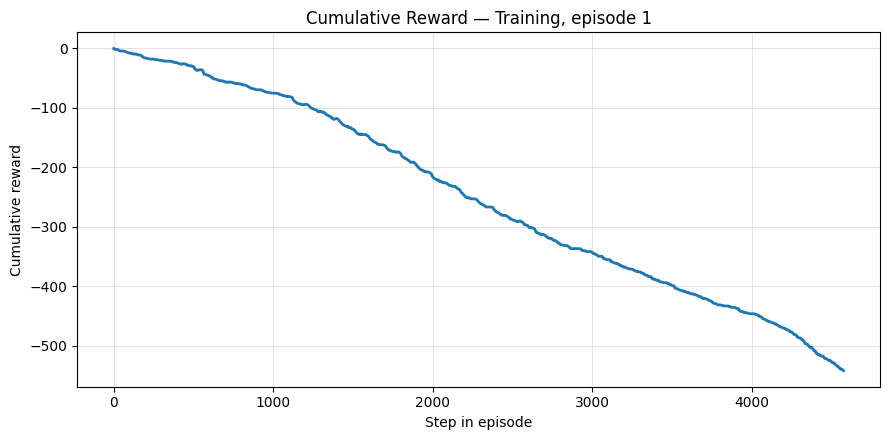

Episode length: 4576 steps | Return: -542.107


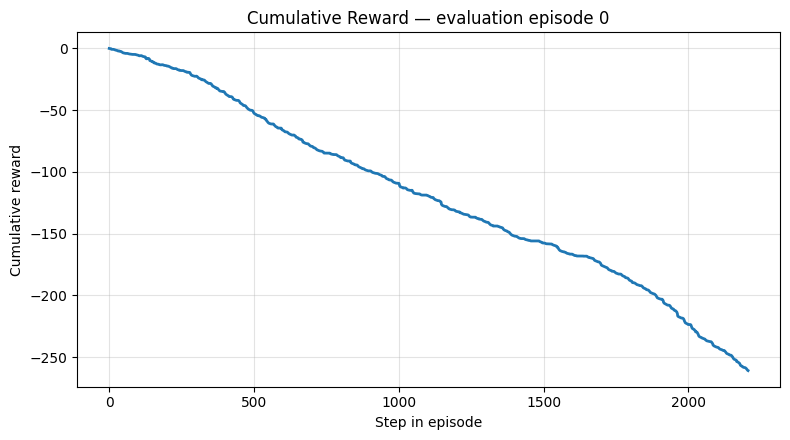

Episode 0 length: 2207 steps | Return: -260.859


In [ ]:
# === Plot cumulative reward for ONE TRAINING episode from TRAIN_STEPS_FILE ===

ENV_ID = 0           # with DummyVecEnv it's usually 0
EPISODE_IDX = 0      # -1 = last available episode for this ENV_ID; otherwise 0,1,2,...

# Load CSV
csv_path = TRAIN_STEPS_FILE  # e.g., os.path.join(LOG_DIR, "ppo_train_steps_01.csv")
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"TRAIN_STEPS_FILE not found: {csv_path}")

df = pd.read_csv(csv_path)

# Clean up column dtypes
for col in ("reward", "env_id", "episode", "global_step"):
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Keep only rows with required fields
need_cols = [c for c in ("env_id", "episode", "reward") if c in df.columns]
df = df.dropna(subset=need_cols)

# Show episode overview per env
episodes_per_env = (
    df.groupby(["env_id", "episode"], as_index=False)["reward"]
      .size()
      .rename(columns={"size": "steps"})
      .sort_values(["env_id", "episode"])
)
print("Episodes available (per env):")
print(episodes_per_env.head(20))

# Select one episode
env_mask = (df["env_id"] == ENV_ID) if "env_id" in df.columns else np.ones(len(df), dtype=bool)
df_env = df.loc[env_mask].copy()
if "episode" not in df_env.columns:
    raise KeyError("CSV has no 'episode' column; cannot segment by episode.")

episodes = sorted(df_env["episode"].dropna().astype(int).unique())
if not episodes:
    raise ValueError(f"No episodes found for env_id={ENV_ID} in {csv_path}")

ep_chosen = episodes[EPISODE_IDX] if EPISODE_IDX != -1 else episodes[-1]
print(f"Plotting env_id={ENV_ID}, episode={ep_chosen}")

# Extract chosen episode in temporal order
order_cols = ["global_step"] if "global_step" in df_env.columns else None
df_ep = df_env.loc[df_env["episode"] == ep_chosen].copy()
if order_cols:
    df_ep = df_ep.sort_values(order_cols)

# Compute cumulative reward
df_ep["reward"] = pd.to_numeric(df_ep["reward"], errors="coerce").fillna(0.0)
df_ep["cum_reward"] = df_ep["reward"].cumsum()
df_ep["t_in_ep"] = np.arange(len(df_ep), dtype=int)

# Plot
plt.figure(figsize=(9, 4.5))
plt.plot(df_ep["t_in_ep"], df_ep["cum_reward"], lw=2)
plt.title(f"Cumulative Reward — Training, episode {ep_chosen}")
plt.xlabel("Step in episode")
plt.ylabel("Cumulative reward")
plt.grid(True, alpha=0.35)
plt.tight_layout()
plt.show()

print(f"Episode length: {len(df_ep)} steps | Return: {df_ep['cum_reward'].iloc[-1]:.3f}")


# === Cumulative reward over timesteps for the FIRST EVALUATION episode (from EVAL_FILE .pkl) ===
assert 'EVAL_FILE' in globals(), "EVAL_FILE is not defined."
if not os.path.exists(EVAL_FILE):
    raise FileNotFoundError(f"Eval file not found: {os.path.abspath(EVAL_FILE)}")

with open(EVAL_FILE, "rb") as f:
    er = pickle.load(f)

def _as_1d_float(x):
    return np.asarray(x, dtype=float).ravel()

def first_episode_step_rewards(data):
    """
    Try common layouts produced by your notebooks:
      - 'ep_rewards_list': list of per-episode step-reward arrays/lists
      - ('step_rewards' + 'ep_lengths'): flat step rewards + per-episode lengths
    Returns: np.ndarray of step rewards for episode 0.
    """
    if isinstance(data, dict):
        # Preferred: list of step-reward sequences per episode
        if "ep_rewards_list" in data and len(data["ep_rewards_list"]) > 0:
            ep0 = data["ep_rewards_list"][0]
            # Some pipelines store floats (already per-episode sum) -> then we can't do cumulative steps
            if isinstance(ep0, (list, tuple, np.ndarray)):
                return _as_1d_float(ep0)

        # Fallback: flat step_rewards segmented by ep_lengths
        if "step_rewards" in data and "ep_lengths" in data:
            step_rewards = _as_1d_float(data["step_rewards"])
            ep_lengths   = np.asarray(data["ep_lengths"], dtype=int).ravel()
            if ep_lengths.size == 0:
                raise ValueError("ep_lengths is empty in eval file.")
            L0 = int(ep_lengths[0])
            if L0 <= 0:
                raise ValueError(f"First episode length is non-positive: {L0}")
            if step_rewards.size < L0:
                raise ValueError(f"Not enough step rewards for first episode: have {step_rewards.size}, need {L0}")
            return step_rewards[:L0]

        # Some variants:
        for k in ("episode_step_rewards", "rewards_per_step", "ep0_step_rewards"):
            if k in data:
                return _as_1d_float(data[k])

    raise ValueError(
        "Could not find per-step rewards for episode 0 in EVAL_FILE. "
        "Expected 'ep_rewards_list' (list of per-step arrays) or ('step_rewards' + 'ep_lengths'). "
        f"Available keys: {list(data.keys()) if isinstance(data, dict) else type(data)}"
    )

# Extract per-step rewards for first eval episode
r0 = first_episode_step_rewards(er)
cum0 = np.cumsum(r0)

# Plot
plt.figure(figsize=(8, 4.5))
plt.plot(np.arange(len(cum0)), cum0, lw=2)
plt.title("Cumulative Reward — evaluation episode 0")
plt.xlabel("Step in episode")
plt.ylabel("Cumulative reward")
plt.grid(True, alpha=0.35)
plt.tight_layout()
plt.show()

print(f"Episode 0 length: {len(r0)} steps | Return: {cum0[-1]:.3f}")

#### DecisionTree

Loading training dataset from /hkfs/home/haicore/iai/cj9272/logs/dqn/dqn_train_steps_50episodes_without_soc.csv ...
Loaded 112769 rows from /hkfs/home/haicore/iai/cj9272/logs/dqn/dqn_train_steps_50episodes_without_soc.csv
n_features: 13 sample: ['battery_energy_balance', 'battery_soc', 'chargers_load', 'cooling_load', 'dhw_load', 'heating_load', 'net_load', 'non_shiftable_load', 'power_outage', 'price']
Fitting 5 folds for each of 480 candidates, totalling 2400 fits
Best balanced_accuracy: 0.5784852769998874
Best params: {'ccp_alpha': 0.0005, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Surrogate Tree Accuracy: 0.509
Confusion matrix (rows=true, cols=pred):
 [[8473 2852  377  119    0]
 [7060 3288  483  110    0]
 [2133  265  830   16    0]
 [   2    0    1  917  125]
 [   3    0    1  299  839]]
                precision    recall  f1-score   support

discharge_full       0.48      0.72      0.57   

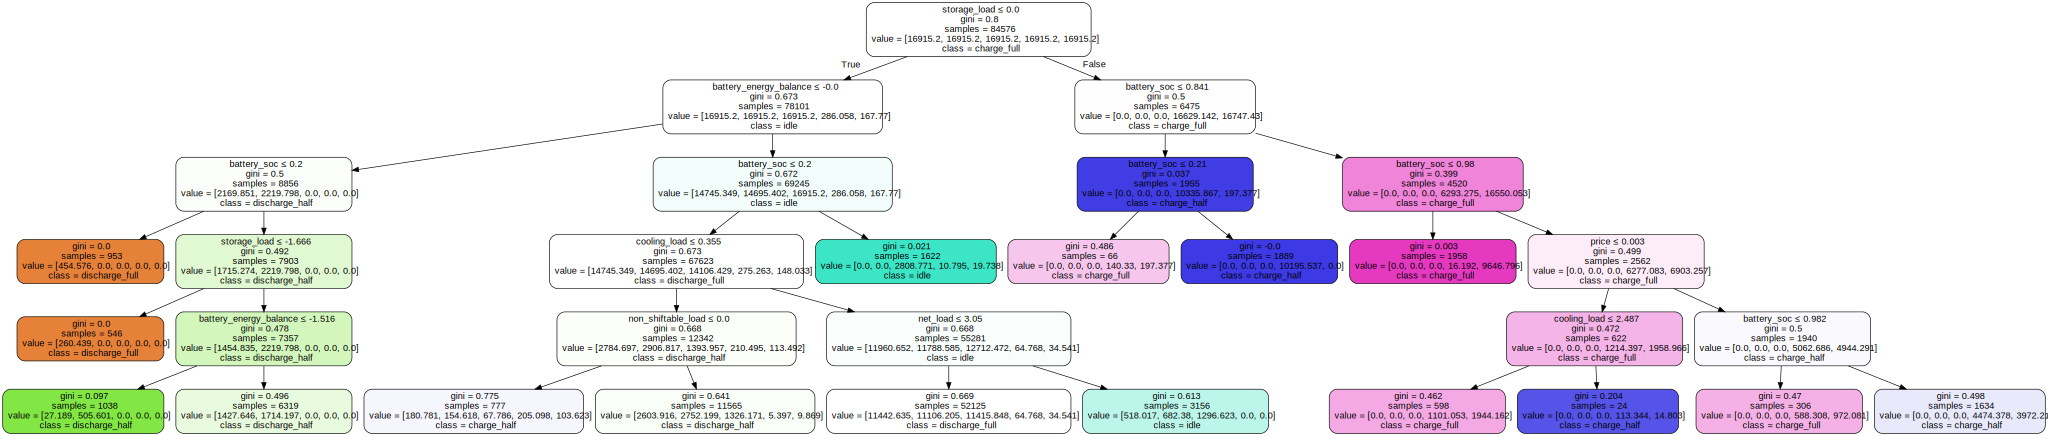

In [ ]:
# ---- Explainability: Decision Tree (state -> action) ---- ca. 2:30min
# Trains a small DecisionTreeClassifier on (observation -> action) pairs from training logs.
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Load logged steps (x0..xN features, 'action' as label)
def _load_policy_dataset(csv_path=None):
    print(f"Loading training dataset from {csv_path} ...")
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        print(f"Loaded {len(df)} rows from {os.path.abspath(csv_path)}")
        return df
    if 'train_callback' in globals() and hasattr(train_callback, 'df') and len(train_callback.df):
        print("Using in-memory train_callback.df")
        return train_callback.df.copy()
    raise FileNotFoundError(f"No training dataset found. Ensure {TRAIN_STEPS_FILE} exists or run training first.")

df_steps = _load_policy_dataset(TRAIN_STEPS_FILE)

target_col = "action_id"
drop = {"global_step", "env_id", "episode", "action_label", "action_frac", "reward", target_col}

num_bool = df_steps.select_dtypes(include=[np.number, bool]).columns
feat_cols = sorted([c for c in num_bool if c not in drop])

assert len(feat_cols) > 0, "No features selected – check your dataframe columns!"
print("n_features:", len(feat_cols), "sample:", feat_cols[:10])

feature_names = list(feat_cols)

X = df_steps[feat_cols].to_numpy()
y = df_steps[target_col].astype(int).to_numpy()
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

"""
# Train a compact tree (tune depth/leaves for your preference)
# Greedily picks the feature and threshold that best split 
# the training data to reduce class impurity (default: gini)
clf = DecisionTreeClassifier(
    criterion="gini", # 
    max_depth=4,
    min_samples_leaf=50,
    random_state=0,
    class_weight="balanced"
)
clf.fit(X_train, y_train)
"""
# Hyperparameter optimization with GridSearchCV
param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [5],
    "min_samples_leaf": [1, 5, 10, 25, 50],
    "min_samples_split": [2, 5, 10, 20],
    "class_weight": [None, "balanced"],
    "ccp_alpha": [0.0, 0.0005, 0.001, 0.005],
    "splitter": ["best"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0) # keeps class proportions similar in each fold
grid = GridSearchCV(
    DecisionTreeClassifier(random_state=0),
    param_grid=param_grid,
    scoring="balanced_accuracy",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)
print("Best balanced_accuracy:", grid.best_score_)
print("Best params:", grid.best_params_)

clf = grid.best_estimator_

# Evaluate fidelity to the DQN policy
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred) # fraction of correctly classified samples
print(f"Surrogate Tree Accuracy: {acc:.3f}")
print("Confusion matrix (rows=true, cols=pred):\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=ACTION_LABELS))

# Global explanations
print("\nTop feature importances:")
imp = clf.feature_importances_
assert len(imp) == len(feature_names), "Mismatch zwischen Importances und Feature-Namen."
imp_idx = np.argsort(imp)[::-1]
for i in imp_idx[:10]:
    if imp[i] <= 0: break
    print(f"- {feature_names[i]}: {imp[i]:.4f}")

#print("\nTree rules (text form):")
#print(export_text(clf, feature_names=feature_names))


# Local explanation for a single timestep
def explain_sample(idx_in_df: int):
    """Print the decision path for a given row index from df_steps."""
    x = df_steps.iloc[idx_in_df][feat_cols].to_numpy().reshape(1, -1)
    true_a = int(df_steps.iloc[idx_in_df][target_col])
    pred_a = int(clf.predict(x)[0])
    proba  = clf.predict_proba(x)[0]
    tree = clf.tree_
    node = 0
    path = []
    while tree.feature[node] != -2:  # -2 => leaf
        f_idx = tree.feature[node]
        thr = tree.threshold[node]
        val = float(x[0, f_idx])
        go_left = val <= thr
        path.append((feature_names[f_idx], val, thr, "left" if go_left else "right"))
        node = tree.children_left[node] if go_left else tree.children_right[node]
    print(f"True action: {true_a} ({ACTION_LABELS[true_a]}), "
          f"Pred: {pred_a} ({ACTION_LABELS[pred_a]}), "
          f"Proba: {dict(zip(ACTION_LABELS, np.round(proba,3)))}")
    print("Decision path:")
    for name, val, thr, side in path:
        print(f" - {name}: {val:.4f} <= {thr:.4f} -> {side}")
    return pred_a

# Example: Random sample from the dataset
_ = explain_sample(idx_in_df=np.random.randint(0, len(df_steps)))

# Visualization with Graphviz (SVG)
try:
    from sklearn.tree import export_graphviz
    import graphviz
    from IPython.display import SVG, display

    dot = export_graphviz(
        clf,
        out_file=None,
        feature_names=feature_names,
        class_names=ACTION_LABELS,
        filled=True,
        rounded=True,
        special_characters=True,
    )
    src = graphviz.Source(dot)
    display(SVG(src.pipe(format='svg')))  # crisp, scalable, no overlaps
except Exception as e:
    print("Graphviz unavailable; falling back to matplotlib (may overlap). Error:", e)
    plt.figure(figsize=(32, 16), dpi=250)
    plot_tree(
        clf,
        feature_names=feature_names,
        class_names=ACTION_LABELS,
        filled=True,
        rounded=True,
        max_depth=4,
        fontsize=14
    )
    plt.tight_layout()
    plt.show()